<a href="https://colab.research.google.com/github/Abdulsalam223/Emotion-Recognition-from-Speech-Codealpha/blob/main/Speech_Emo_Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# STEP 1: IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, GRU
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers as L
from tqdm import tqdm
import timeit
import pickle
from tensorflow.keras.models import model_from_json

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Done")


Done


In [2]:
!apt-get update -q
!apt-get install -y libsndfile1 -q
print("done")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,227 kB]
Get:5 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restrict

In [4]:
import kagglehub
path = kagglehub.dataset_download("barelydedicated/savee-database")

100%|██████████| 215M/215M [00:10<00:00, 21.4MB/s]

Extracting files...


In [7]:
import kagglehub
path = kagglehub.dataset_download("ejlok1/cremad")

Using Colab cache for faster access to the 'cremad' dataset.


In [8]:
import kagglehub
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.


In [15]:
import kagglehub
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.


In [11]:
# ============================================================================
# Find CREMA-D and TESS in Colab cache
# ============================================================================

import os

print("Searching for CREMA-D and TESS datasets in all cache locations...")
print("="*80)

# Search common cache locations
cache_locations = [
    "/root/.cache",
    "/root/.cache/colab",
    "/root/.cache/kagglehub",
    os.path.expanduser("~/.cache"),
]

def find_datasets_recursive(base_path, dataset_keywords):
    """Recursively search for datasets"""
    found = {}
    try:
        for root, dirs, files in os.walk(base_path):
            for keyword in dataset_keywords:
                if keyword.lower() in root.lower():
                    # Check if it contains audio files
                    has_audio = any(f.endswith('.wav') for f in files)
                    if has_audio or any(d for d in dirs):
                        if keyword not in found:
                            found[keyword] = []
                        found[keyword].append(root)
    except Exception as e:
        pass
    return found

# Search for datasets
all_found = {}
for cache_loc in cache_locations:
    if os.path.exists(cache_loc):
        print(f"\nSearching in: {cache_loc}")
        found = find_datasets_recursive(cache_loc, ['cremad', 'crema', 'tess', 'toronto'])
        for key, paths in found.items():
            if key not in all_found:
                all_found[key] = []
            all_found[key].extend(paths)

print("\n" + "="*80)
print("Found datasets:")
print("="*80)
for dataset, paths in all_found.items():
    print(f"\n{dataset.upper()}:")
    for path in paths[:5]:  # Show first 5 matches
        print(f"  - {path}")
        # Count files
        wav_count = sum(1 for r, d, f in os.walk(path) for file in f if file.endswith('.wav'))
        print(f"    WAV files: {wav_count}")

# Now let's also check if kagglehub stored them differently
print("\n" + "="*80)
print("Checking kagglehub datasets folder structure:")
print("="*80)

kagglehub_datasets = "/root/.cache/kagglehub/datasets"
if os.path.exists(kagglehub_datasets):
    for item in os.listdir(kagglehub_datasets):
        item_path = os.path.join(kagglehub_datasets, item)
        if os.path.isdir(item_path):
            print(f"\n{item}:")
            # Show subdirectories
            try:
                for subitem in os.listdir(item_path)[:5]:
                    subitem_path = os.path.join(item_path, subitem)
                    print(f"  - {subitem}")
                    if os.path.isdir(subitem_path):
                        for subsubitem in os.listdir(subitem_path)[:3]:
                            print(f"    - {subsubitem}")
            except:
                pass

Searching for CREMA-D and TESS datasets in all cache locations...

Searching in: /root/.cache

Searching in: /root/.cache/kagglehub

Searching in: /root/.cache

Found datasets:

Checking kagglehub datasets folder structure:

barelydedicated:
  - savee-database
    - 1.complete
    - versions


In [12]:
# ============================================================================
# Re-download and capture paths + explore full cache
# ============================================================================

import os
import kagglehub

print("Re-downloading datasets to capture exact paths...")
print("="*80)

# Download and capture paths
print("\n1. Downloading SAVEE...")
savee_path = kagglehub.dataset_download("barelydedicated/savee-database")
print(f"SAVEE path: {savee_path}")

print("\n2. Downloading CREMA-D...")
crema_path = kagglehub.dataset_download("ejlok1/cremad")
print(f"CREMA-D path: {crema_path}")

print("\n3. Downloading TESS...")
tess_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print(f"TESS path: {tess_path}")

print("\n" + "="*80)
print("Exploring downloaded paths:")
print("="*80)

def explore_and_find_audio(path, dataset_name):
    """Explore path and find where audio files are"""
    print(f"\n{dataset_name}:")
    print(f"Base path: {path}")

    if not os.path.exists(path):
        print(f"  ERROR: Path does not exist!")
        return None

    # List immediate contents
    print(f"  Contents:")
    try:
        items = os.listdir(path)
        for item in items[:10]:
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                print(f"    [DIR]  {item}")
                # Show subdirectory contents
                subitems = os.listdir(item_path)[:5]
                for subitem in subitems:
                    print(f"           - {subitem}")
            else:
                print(f"    [FILE] {item}")
    except Exception as e:
        print(f"  Error listing contents: {e}")

    # Find audio files
    audio_path = None
    max_audio_count = 0

    for root, dirs, files in os.walk(path):
        wav_files = [f for f in files if f.endswith('.wav')]
        if len(wav_files) > max_audio_count:
            max_audio_count = len(wav_files)
            audio_path = root

    print(f"  Audio files found: {max_audio_count}")
    print(f"  Best audio path: {audio_path}")

    return audio_path

# Explore each dataset
Savee = explore_and_find_audio(savee_path, "SAVEE")
Crema = explore_and_find_audio(crema_path, "CREMA-D")
Tess = explore_and_find_audio(tess_path, "TESS")

print("\n" + "="*80)
print("FINAL DATASET PATHS:")
print("="*80)
print(f"SAVEE: {Savee}")
print(f"CREMA-D: {Crema}")
print(f"TESS: {Tess}")
print("="*80)

Re-downloading datasets to capture exact paths...

1. Downloading SAVEE...
Using Colab cache for faster access to the 'savee-database' dataset.
SAVEE path: /kaggle/input/savee-database

2. Downloading CREMA-D...
Using Colab cache for faster access to the 'cremad' dataset.
CREMA-D path: /kaggle/input/cremad

3. Downloading TESS...
Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
TESS path: /kaggle/input/toronto-emotional-speech-set-tess

Exploring downloaded paths:

SAVEE:
Base path: /kaggle/input/savee-database
  Contents:
    [DIR]  AudioData
           - DC
           - Info.txt
           - JE
           - KL
           - JK
    [DIR]  audiodata
           - AudioData
  Audio files found: 120
  Best audio path: /kaggle/input/savee-database/AudioData/DC

CREMA-D:
Base path: /kaggle/input/cremad
  Contents:
    [DIR]  AudioWAV
           - 1028_TSI_DIS_XX.wav
           - 1075_IEO_HAP_LO.wav
           - 1084_ITS_HAP_XX.wav
           - 1067_IWW_

In [19]:
# ============================================================================
# STEP 2: DATASET PATHS (Corrected for Colab/Kagglehub) - FINAL VERSION
# ============================================================================

import os
import kagglehub

print("Setting up dataset paths...")
print("="*80)

# Download datasets (will use cache if already downloaded)
savee_base = kagglehub.dataset_download("barelydedicated/savee-database")
crema_base = kagglehub.dataset_download("ejlok1/cremad")
tess_base = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

# Download the combined dataset that includes RAVDESS
combined_base = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")

# Set correct paths to audio files
# SAVEE: From original download
Savee = os.path.join(savee_base, "AudioData")

# CREMA-D: From original download
Crema = os.path.join(crema_base, "AudioWAV")

# TESS: From original download
Tess = os.path.join(tess_base, "TESS Toronto emotional speech set data")

# RAVDESS: From combined dataset
ravdess = os.path.join(combined_base, "Ravdess", "audio_speech_actors_01-24")

print("\n" + "="*80)
print("Dataset Paths:")
print("="*80)
print(f"SAVEE: {Savee}")
print(f"CREMA-D: {Crema}")
print(f"TESS: {Tess}")
print(f"RAVDESS: {ravdess}")
print("="*80)

# Verify paths and count files
print("\nVerifying datasets...")
print("="*80)

if os.path.exists(Savee):
    savee_speakers = [d for d in os.listdir(Savee) if os.path.isdir(os.path.join(Savee, d))]
    savee_files = []
    for root, dirs, files in os.walk(Savee):
        savee_files.extend([f for f in files if f.endswith('.wav')])
    print(f"✓ SAVEE: {len(savee_files)} audio files from {len(savee_speakers)} speakers")
    print(f"  Speakers: {savee_speakers}")
else:
    print(f"✗ SAVEE path does not exist: {Savee}")

if os.path.exists(Crema):
    crema_files = [f for f in os.listdir(Crema) if f.endswith('.wav')]
    print(f"✓ CREMA-D: {len(crema_files)} audio files")
else:
    print(f"✗ CREMA-D path does not exist: {Crema}")

if os.path.exists(Tess):
    tess_folders = [d for d in os.listdir(Tess) if os.path.isdir(os.path.join(Tess, d))]
    tess_files = []
    for root, dirs, files in os.walk(Tess):
        tess_files.extend([f for f in files if f.endswith('.wav')])
    print(f"✓ TESS: {len(tess_files)} audio files from {len(tess_folders)} emotion folders")
    print(f"  Emotion folders: {tess_folders[:5]}...")
else:
    print(f"✗ TESS path does not exist: {Tess}")

if os.path.exists(ravdess):
    ravdess_actors = [d for d in os.listdir(ravdess) if os.path.isdir(os.path.join(ravdess, d)) and 'Actor' in d]
    ravdess_files = []
    for root, dirs, files in os.walk(ravdess):
        ravdess_files.extend([f for f in files if f.endswith('.wav')])
    print(f"✓ RAVDESS: {len(ravdess_files)} audio files from {len(ravdess_actors)} actors")
    print(f"  Actors: {ravdess_actors[:5]}...")
else:
    print(f"✗ RAVDESS path does not exist: {ravdess}")

print("="*80)
print("Setup complete! ✓")
print("="*80)

Setting up dataset paths...
Using Colab cache for faster access to the 'savee-database' dataset.
Using Colab cache for faster access to the 'cremad' dataset.
Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
Using Colab cache for faster access to the 'speech-emotion-recognition-en' dataset.

Dataset Paths:
SAVEE: /kaggle/input/savee-database/AudioData
CREMA-D: /kaggle/input/cremad/AudioWAV
TESS: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data
RAVDESS: /kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24

Verifying datasets...
✓ SAVEE: 480 audio files from 4 speakers
  Speakers: ['DC', 'JE', 'KL', 'JK']
✓ CREMA-D: 7442 audio files
✓ TESS: 2800 audio files from 14 emotion folders
  Emotion folders: ['YAF_fear', 'OAF_angry', 'OAF_Fear', 'OAF_disgust', 'OAF_neutral']...
✓ RAVDESS: 1440 audio files from 24 actors
  Actors: ['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21']...
Setu

In [20]:
# ============================================================================
# STEP 3: PREPROCESSING ALL DATASETS
# ============================================================================

import pandas as pd

print("Processing datasets...")
print("="*80)

# ============================================================================
# 3.1: RAVDESS Dataset
# ============================================================================
print("\n1. Processing RAVDESS Dataset...")

ravdess_directory_list = os.listdir(ravdess)
print(f"RAVDESS Actors: {ravdess_directory_list[:5]}...")

file_emotion = []
file_path = []

for actor_folder in ravdess_directory_list:
    if not actor_folder.startswith('Actor_'):
        continue

    actor_path = os.path.join(ravdess, actor_folder)
    if not os.path.isdir(actor_path):
        continue

    actor_files = os.listdir(actor_path)
    for f in actor_files:
        if f.endswith('.wav'):
            part = f.split('.')[0].split('-')
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(actor_path, f))

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad',
                              5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},
                            inplace=True)

print(f"RAVDESS: {len(ravdess_df)} files processed")
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print("Emotion distribution:")
print(ravdess_df.Emotions.value_counts())

# ============================================================================
# 3.2: SAVEE Dataset
# ============================================================================
print("\n" + "="*80)
print("2. Processing SAVEE Dataset...")

file_emotion = []
file_path = []

# SAVEE naming convention: {speaker_id}{emotion_code}{number}.wav
# Emotion codes: a=anger, d=disgust, f=fear, h=happiness, n=neutral, sa=sadness, su=surprise
emotion_map = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'
}

for speaker in os.listdir(Savee):
    speaker_path = os.path.join(Savee, speaker)
    if os.path.isdir(speaker_path):
        for file in os.listdir(speaker_path):
            if file.endswith('.wav'):
                # Extract emotion from filename (e.g., 'a01.wav' -> 'a')
                file_name = file.split('.')[0]

                # Check for two-letter emotions first (sa, su)
                if len(file_name) >= 2 and file_name[:2] in emotion_map:
                    emotion_code = file_name[:2]
                elif len(file_name) >= 1 and file_name[0] in emotion_map:
                    emotion_code = file_name[0]
                else:
                    continue

                file_emotion.append(emotion_map[emotion_code])
                file_path.append(os.path.join(speaker_path, file))

savee_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})
print(f"SAVEE: {len(savee_df)} files processed")
print(savee_df.head())
print("\nEmotion distribution:")
print(savee_df.Emotions.value_counts())

# ============================================================================
# 3.3: CREMA-D Dataset
# ============================================================================
print("\n" + "="*80)
print("3. Processing CREMA-D Dataset...")

file_emotion = []
file_path = []

# CREMA-D naming: {ActorID}_{SentenceID}_{Emotion}_{Intensity}.wav
# Emotions: ANG=angry, DIS=disgust, FEA=fear, HAP=happy, NEU=neutral, SAD=sad
emotion_map = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

for file in os.listdir(Crema):
    if file.endswith('.wav'):
        parts = file.split('_')
        if len(parts) >= 3:
            emotion_code = parts[2]
            if emotion_code in emotion_map:
                file_emotion.append(emotion_map[emotion_code])
                file_path.append(os.path.join(Crema, file))

crema_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})
print(f"CREMA-D: {len(crema_df)} files processed")
print(crema_df.head())
print("\nEmotion distribution:")
print(crema_df.Emotions.value_counts())

# ============================================================================
# 3.4: TESS Dataset
# ============================================================================
print("\n" + "="*80)
print("4. Processing TESS Dataset...")

file_emotion = []
file_path = []

# TESS folder structure: {Speaker}_{emotion}/
# Folders: OAF_angry, OAF_disgust, YAF_fear, etc.
for folder in os.listdir(Tess):
    folder_path = os.path.join(Tess, folder)
    if os.path.isdir(folder_path):
        # Extract emotion from folder name (e.g., 'OAF_angry' -> 'angry')
        emotion = folder.split('_')[-1].lower()

        # Normalize emotion names
        if emotion == 'ps':  # pleasant surprise
            emotion = 'surprise'

        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_emotion.append(emotion)
                file_path.append(os.path.join(folder_path, file))

tess_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})
print(f"TESS: {len(tess_df)} files processed")
print(tess_df.head())
print("\nEmotion distribution:")
print(tess_df.Emotions.value_counts())

# ============================================================================
# 3.5: Combine All Datasets
# ============================================================================
print("\n" + "="*80)
print("5. Combining all datasets...")

combined_df = pd.concat([ravdess_df, savee_df, crema_df, tess_df], axis=0, ignore_index=True)

print(f"\nTotal files: {len(combined_df)}")
print("\nCombined dataset head:")
print(combined_df.head(10))
print("\nCombined dataset tail:")
print(combined_df.tail(10))
print("\n" + "="*80)
print("Overall emotion distribution:")
print("="*80)
print(combined_df.Emotions.value_counts())

print("\n" + "="*80)
print("Preprocessing complete! ✓")
print("="*80)

Processing datasets...

1. Processing RAVDESS Dataset...
RAVDESS Actors: ['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21']...
RAVDESS: 1440 files processed
   Emotions                                               Path
0  surprise  /kaggle/input/speech-emotion-recognition-en/Ra...
1   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...
2   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
3   disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
4   neutral  /kaggle/input/speech-emotion-recognition-en/Ra...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/speech-emotion-recognition-en/Ra...
1436    angry  /kaggle/input/speech-emotion-recognition-en/Ra...
1437      sad  /kaggle/input/speech-emotion-recognition-en/Ra...
1438  disgust  /kaggle/input/speech-emotion-recognition-en/Ra...
1439    angry  /kaggle/input/speech-emotion-recognition-en/Ra...
__________________

/tmp/ipython-input-3305060463.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad',


Creating visualizations...


/tmp/ipython-input-873737336.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=combined_df, palette='Set2')


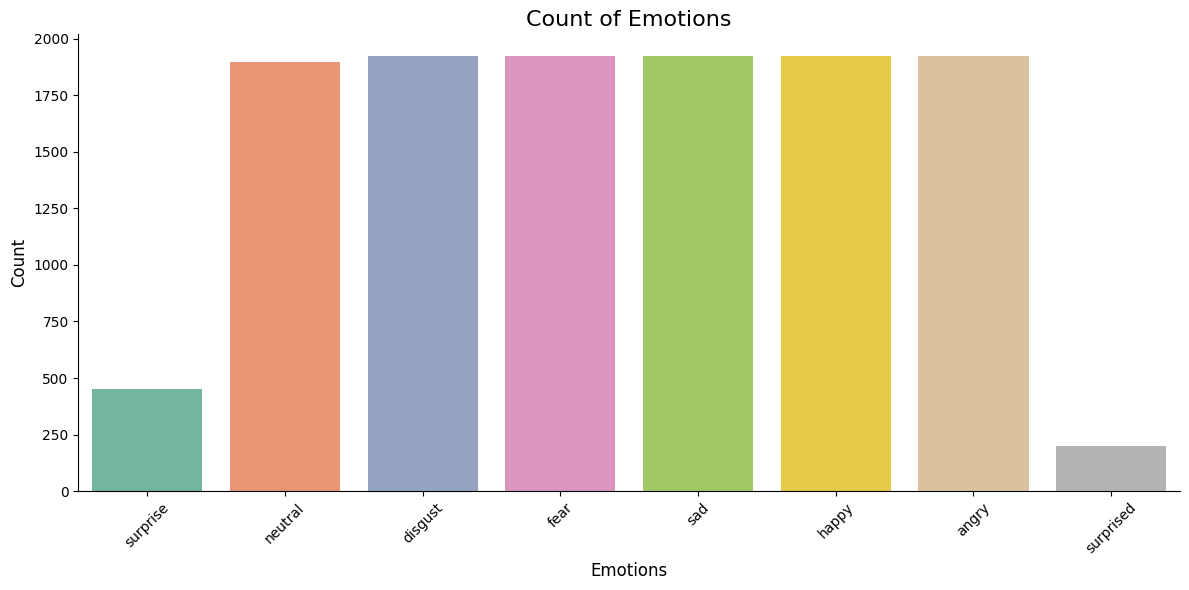


Total audio files: 12162

Emotion distribution:
Emotions
fear         1923
disgust      1923
happy        1923
sad          1923
angry        1923
neutral      1895
surprise      452
surprised     200
Name: count, dtype: int64

Loading sample audio file...
Sample file: /kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
Sample Rate: 22050 Hz
Duration: 3.54 seconds
Audio shape: (77988,)

Playing audio...



Creating Mel Spectrogram...


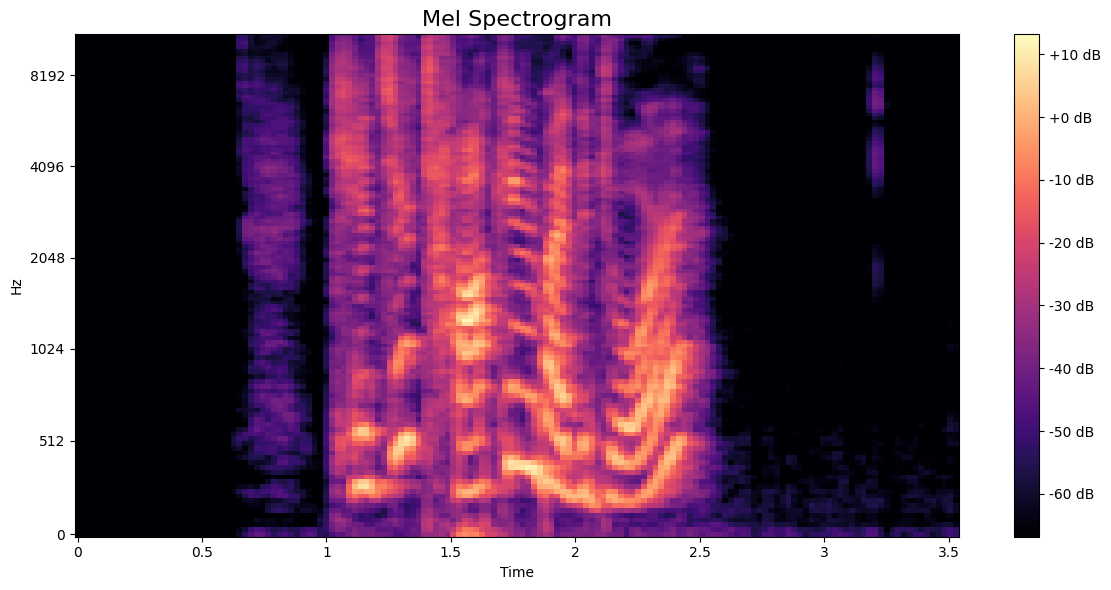


Creating MFCC...


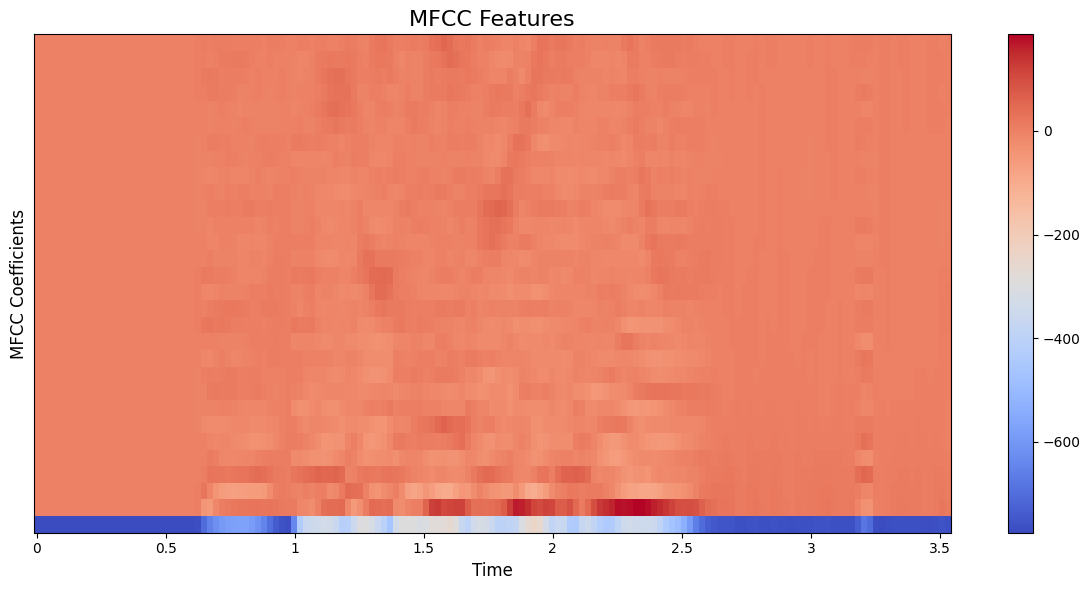


Visualization complete! ✓

Defining Data Augmentation Functions...
✓ Augmentation functions defined

Visualizing Data Augmentation Effects...


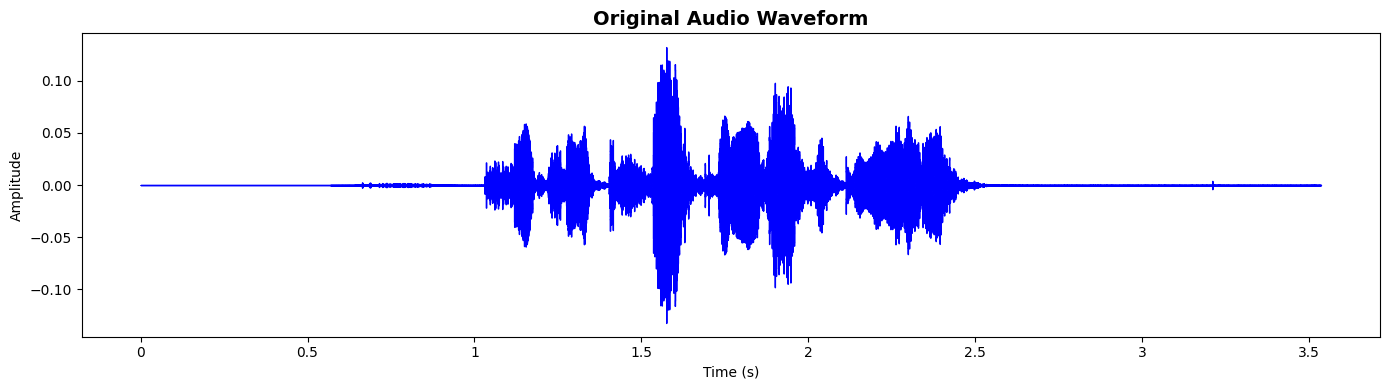

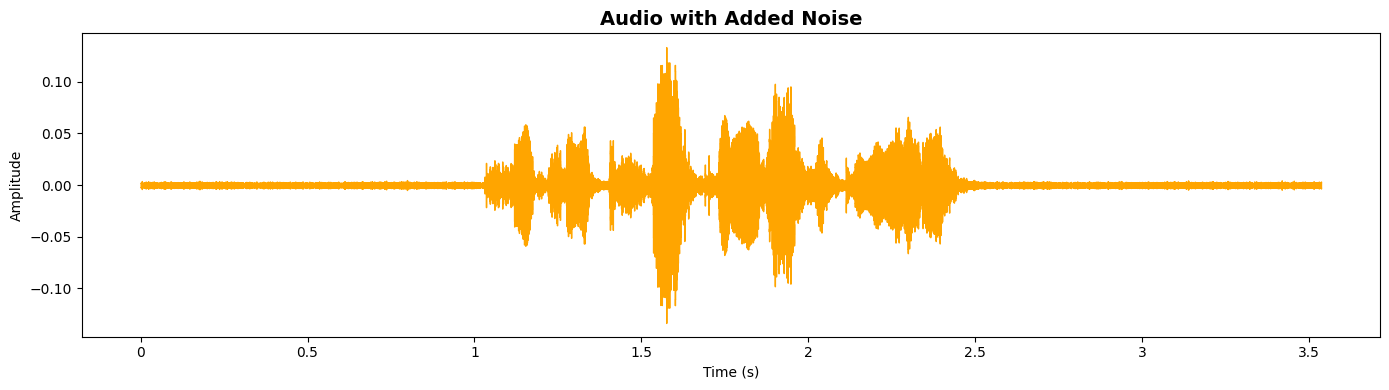

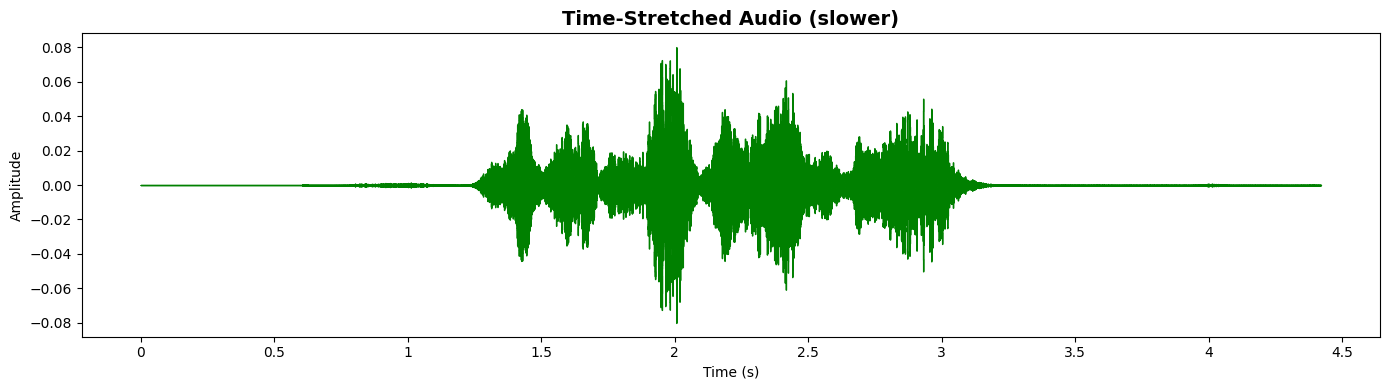

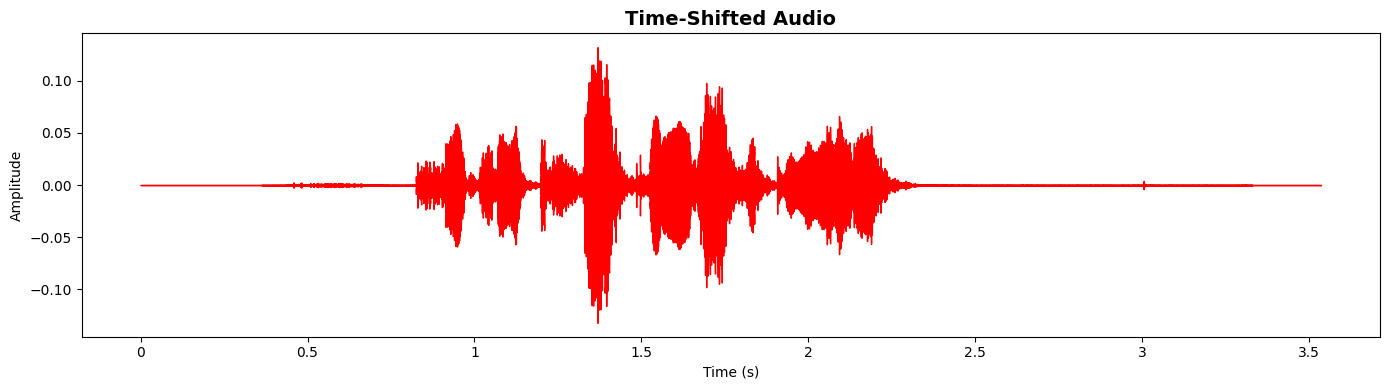

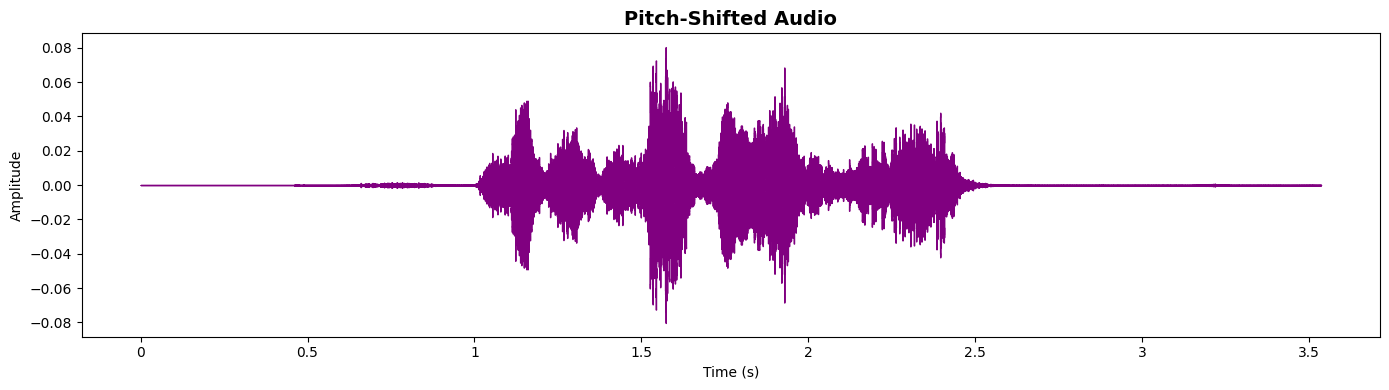


Data augmentation visualization complete! ✓


In [21]:
# ============================================================================
# STEP 8: DATA VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np

print("Creating visualizations...")
print("="*80)

# Emotion Distribution Plot
plt.figure(figsize=(12, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=combined_df, palette='Set2')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nTotal audio files: {len(combined_df)}")
print("\nEmotion distribution:")
print(combined_df.Emotions.value_counts())

# ============================================================================
# Load and Display Sample Audio
# ============================================================================
print("\n" + "="*80)
print("Loading sample audio file...")
print("="*80)

# Get a sample audio file path
sample_path = combined_df.Path.iloc[0]
print(f"Sample file: {sample_path}")

# Load audio
data, sr = librosa.load(sample_path)
print(f"Sample Rate: {sr} Hz")
print(f"Duration: {len(data)/sr:.2f} seconds")
print(f"Audio shape: {data.shape}")

# Play audio
print("\nPlaying audio...")
ipd.display(ipd.Audio(data, rate=sr))

# ============================================================================
# Mel Spectrogram Visualization
# ============================================================================
print("\nCreating Mel Spectrogram...")

plt.figure(figsize=(12, 6))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time')
plt.title('Mel Spectrogram', size=16)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# ============================================================================
# MFCC Visualization
# ============================================================================
print("\nCreating MFCC...")

mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
plt.figure(figsize=(12, 6))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.ylabel('MFCC Coefficients', size=12)
plt.xlabel('Time', size=12)
plt.title('MFCC Features', size=16)
plt.colorbar()
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Visualization complete! ✓")
print("="*80)

# ============================================================================
# STEP 9: DATA AUGMENTATION FUNCTIONS
# ============================================================================

print("\n" + "="*80)
print("Defining Data Augmentation Functions...")
print("="*80)

def noise(data):
    """Add random noise to audio"""
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Time stretch audio"""
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    """Shift audio in time"""
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    """Shift pitch of audio"""
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

print("✓ Augmentation functions defined")

# ============================================================================
# Visualize Augmentations
# ============================================================================
print("\n" + "="*80)
print("Visualizing Data Augmentation Effects...")
print("="*80)

# Original Audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sr, color='blue')
plt.title('Original Audio Waveform', size=14, weight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Audio with Noise
x = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sr, color='orange')
plt.title('Audio with Added Noise', size=14, weight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Stretched Audio
x = stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sr, color='green')
plt.title('Time-Stretched Audio (slower)', size=14, weight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Shifted Audio
x = shift(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sr, color='red')
plt.title('Time-Shifted Audio', size=14, weight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Pitch-Shifted Audio
x = pitch(data, sr)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sr, color='purple')
plt.title('Pitch-Shifted Audio', size=14, weight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Data augmentation visualization complete! ✓")
print("="*80)

In [22]:
# ============================================================================
# STEP 10: FEATURE EXTRACTION FUNCTIONS
# ============================================================================

import librosa
import numpy as np

print("Defining Feature Extraction Functions...")
print("="*80)

def zcr(data, frame_length=2048, hop_length=512):
    """
    Zero Crossing Rate: Measures how often the signal changes sign
    Useful for distinguishing voiced vs unvoiced speech
    """
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    """
    Root Mean Square Energy: Measures the energy/loudness of the audio
    """
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    """
    Mel-Frequency Cepstral Coefficients: Represents the short-term power spectrum
    Most important feature for speech emotion recognition
    """
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    """
    Extract multiple audio features and concatenate them
    Returns: Combined feature vector
    """
    result = np.array([])

    # Extract ZCR
    zcr_feature = zcr(data, frame_length, hop_length)

    # Extract RMSE
    rmse_feature = rmse(data, frame_length, hop_length)

    # Extract MFCC
    mfcc_feature = mfcc(data, sr, frame_length, hop_length)

    # Concatenate all features
    result = np.hstack((result, zcr_feature, rmse_feature, mfcc_feature))

    return result

def get_features(path, duration=2.5, offset=0.6):
    """
    Extract features from audio file with data augmentation

    Args:
        path: Path to audio file
        duration: Duration of audio to load (seconds)
        offset: Start reading after this time (seconds)

    Returns:
        Array of shape (4, num_features) containing:
        - Original audio features
        - Noised audio features
        - Pitch-shifted audio features
        - Pitch-shifted + noised audio features
    """
    # Load audio file
    data, sr = librosa.load(path, duration=duration, offset=offset)

    # 1. Extract features from original audio
    aud1 = extract_features(data, sr)
    audio = np.array(aud1)

    # 2. Add noise and extract features
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio, sr)
    audio = np.vstack((audio, aud2))

    # 3. Pitch shift and extract features
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio, sr)
    audio = np.vstack((audio, aud3))

    # 4. Pitch shift + noise and extract features
    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1)
    aud4 = extract_features(pitched_noised_audio, sr)
    audio = np.vstack((audio, aud4))

    return audio

print("✓ Feature extraction functions defined")

# ============================================================================
# Test Feature Extraction
# ============================================================================
print("\n" + "="*80)
print("Testing Feature Extraction...")
print("="*80)

# Test on a sample file
sample_path = combined_df.Path.iloc[0]
print(f"Testing on: {sample_path}")

try:
    features = get_features(sample_path)
    print(f"\n✓ Feature extraction successful!")
    print(f"Feature matrix shape: {features.shape}")
    print(f"  - Number of augmented versions: {features.shape[0]}")
    print(f"  - Features per sample: {features.shape[1]}")

    # Show what each row represents
    print("\nFeature matrix breakdown:")
    print("  Row 0: Original audio features")
    print("  Row 1: Noised audio features")
    print("  Row 2: Pitch-shifted audio features")
    print("  Row 3: Pitch-shifted + noised audio features")

except Exception as e:
    print(f"\n✗ Error during feature extraction: {e}")

print("\n" + "="*80)
print("Feature extraction setup complete! ✓")
print("="*80)

Defining Feature Extraction Functions...
✓ Feature extraction functions defined

Testing Feature Extraction...
Testing on: /kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav

✓ Feature extraction successful!
Feature matrix shape: (4, 1620)
  - Number of augmented versions: 4
  - Features per sample: 1620

Feature matrix breakdown:
  Row 0: Original audio features
  Row 1: Noised audio features
  Row 2: Pitch-shifted audio features
  Row 3: Pitch-shifted + noised audio features

Feature extraction setup complete! ✓


In [23]:
# ============================================================================
# STEP 11: EXTRACT FEATURES FROM ALL AUDIO FILES (PARALLEL - FASTER)
# ============================================================================

from joblib import Parallel, delayed
import timeit

print("="*80)
print("PARALLEL FEATURE EXTRACTION")
print("="*80)

# Define a function to get features for a single audio file
def process_feature(path, emotion):
    """
    Extract features from a single audio file with augmentation

    Args:
        path: Path to audio file
        emotion: Emotion label for the audio

    Returns:
        X: List of feature vectors (4 per audio due to augmentation)
        Y: List of corresponding emotion labels (4 per audio)
    """
    try:
        features = get_features(path)
        X = []
        Y = []
        for ele in features:
            X.append(ele)
            # Appending emotion 4 times as we have made 4 augmentation techniques on each audio file
            Y.append(emotion)
        return X, Y
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return [], []

# Get paths and emotions from combined dataset
paths = combined_df.Path.values
emotions = combined_df.Emotions.values

print(f"\nProcessing {len(paths)} audio files...")
print(f"Expected output: {len(paths) * 4} samples (4x augmentation)")
print(f"Using all available CPU cores...\n")

# Start timer
start = timeit.default_timer()

# Run the loop in parallel using all CPU cores
# n_jobs=-1 uses all available cores
# verbose=10 shows progress
print("Starting parallel processing...")
print("="*80)

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_feature)(path, emotion)
    for path, emotion in zip(paths, emotions)
)

# Collect the results
X = []
Y = []

for result in results:
    x, y = result
    if x:  # Only extend if result is not empty
        X.extend(x)
        Y.extend(y)

# Stop timer
stop = timeit.default_timer()

# Display results
print("\n" + "="*80)
print("EXTRACTION COMPLETE!")
print("="*80)
print(f"✓ Time taken: {stop - start:.2f} seconds ({(stop - start)/60:.2f} minutes)")
print(f"✓ Original audio files: {len(paths)}")
print(f"✓ Features extracted: {len(X)} samples")
print(f"✓ Labels created: {len(Y)} labels")
print(f"✓ Augmentation factor: {len(X) / len(paths):.1f}x")
print(f"✓ Feature vector size: {len(X[0]) if X else 0}")

# Verify data
if len(X) == len(Y):
    print(f"✓ Data consistency check: PASSED")
else:
    print(f"✗ Warning: Mismatch between features ({len(X)}) and labels ({len(Y)})")

# Convert to numpy arrays for model training
X = np.array(X)
Y = np.array(Y)

print(f"\n✓ Final shapes:")
print(f"  X (features): {X.shape}")
print(f"  Y (labels): {Y.shape}")

print("\n" + "="*80)
print("Ready for model training! ✓")
print("="*80)

PARALLEL FEATURE EXTRACTION

Processing 12162 audio files...
Expected output: 48648 samples (4x augmentation)
Using all available CPU cores...

Starting parallel processing...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   


EXTRACTION COMPLETE!
✓ Time taken: 800.53 seconds (13.34 minutes)
✓ Original audio files: 12162
✓ Features extracted: 48648 samples
✓ Labels created: 48648 labels
✓ Augmentation factor: 4.0x
✓ Feature vector size: 1620
✓ Data consistency check: PASSED


[Parallel(n_jobs=-1)]: Done 12162 out of 12162 | elapsed: 13.3min finished


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (48648,) + inhomogeneous part.

In [26]:
print("\n" + "="*80)
print("FIXING VARIABLE FEATURE LENGTH ISSUE")
print("="*80)

# IMPORTANT: X must be a LIST here, not a NumPy array
print(f"Number of samples before padding: {len(X)}")

# Find max feature length
max_len = max(len(x) for x in X)
print(f"Maximum feature length: {max_len}")

# Pad / truncate features
X_fixed = []
for x in X:
    if len(x) < max_len:
        x = np.pad(x, (0, max_len - len(x)), mode='constant')
    else:
        x = x[:max_len]
    X_fixed.append(x)

# Replace X
X = X_fixed

print("✓ Feature length normalization complete")

# NOW convert to NumPy arrays (SAFE)
X = np.array(X, dtype=np.float32)
Y = np.array(Y)

print(f"Final X shape: {X.shape}")
print(f"Final Y shape: {Y.shape}")
print("="*80)



FIXING VARIABLE FEATURE LENGTH ISSUE
Number of samples before padding: 48648
Maximum feature length: 1620
✓ Feature length normalization complete
Final X shape: (48648, 1620)
Final Y shape: (48648,)


# **saving features and Data preparation**

In [27]:
# ============================================================================
# STEP 12: SAVE FEATURES (CLEAN VERSION)
# ============================================================================

import pandas as pd
import numpy as np

print("="*80)
print("STEP 12: SAVING FEATURES")
print("="*80)

# Convert extracted features to DataFrame
features_df = pd.DataFrame(X)
features_df['Emotions'] = Y

# Handle NaN values BEFORE saving
features_df.fillna(0, inplace=True)

# Save to CSV
features_df.to_csv("emotion.csv", index=False)

print(f"✓ Features saved successfully")
print(f"✓ Dataset shape: {features_df.shape}")
print(f"✓ Total NaN values: {features_df.isna().sum().sum()}")

features_df.head()


# ============================================================================
# STEP 13: DATA PREPARATION
# ============================================================================

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print("STEP 13: DATA PREPARATION")
print("="*80)

# Separate features and labels
X = features_df.drop('Emotions', axis=1).values
Y = features_df['Emotions'].values

print(f"Initial X shape: {X.shape}")
print(f"Initial Y shape: {Y.shape}")

# One-Hot Encode emotion labels
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y.reshape(-1, 1))

print(f"One-hot encoded Y shape: {Y.shape}")

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

print(f"Train set: {x_train.shape}, {y_train.shape}")
print(f"Test set:  {x_test.shape}, {y_test.shape}")

# Feature Scaling (IMPORTANT: before CNN reshape)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape for CNN input: (samples, features, 1)
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

print("\nFinal shapes for CNN:")
print(f"x_traincnn: {x_traincnn.shape}")
print(f"x_testcnn:  {x_testcnn.shape}")
print(f"y_train:    {y_train.shape}")
print(f"y_test:     {y_test.shape}")

print("\n✓ Data preparation complete!")
print("="*80)


STEP 12: SAVING FEATURES
✓ Features saved successfully
✓ Dataset shape: (48648, 1621)
✓ Total NaN values: 0

STEP 13: DATA PREPARATION
Initial X shape: (48648, 1620)
Initial Y shape: (48648,)
One-hot encoded Y shape: (48648, 8)
Train set: (38918, 1620), (38918, 8)
Test set:  (9730, 1620), (9730, 8)

Final shapes for CNN:
x_traincnn: (38918, 1620, 1)
x_testcnn:  (9730, 1620, 1)
y_train:    (38918, 8)
y_test:     (9730, 8)

✓ Data preparation complete!


# **CNN model**

In [31]:
# ============================================================================
# STEP 14: BUILD CNN MODEL
# ============================================================================

model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_traincnn.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.2),

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 1620, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1620, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 810, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 810, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 810, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 405, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 405, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 203, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 203, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 203, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 102, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 102, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6528)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,10

 Total params: 5,620,872 (21.44 MB)

 Trainable params: 5,616,520 (21.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

# **Traning and Evaluating Model**

Epoch 1/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.3892 - loss: 1.7145

609/609 ━━━━━━━━━━━━━━━━━━━━ 161s 224ms/step - accuracy: 0.3892 - loss: 1.7141 - val_accuracy: 0.3956 - val_loss: 1.5570 - learning_rate: 0.0010
Epoch 2/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5030 - loss: 1.2761

609/609 ━━━━━━━━━━━━━━━━━━━━ 124s 204ms/step - accuracy: 0.5030 - loss: 1.2759 - val_accuracy: 0.5186 - val_loss: 1.2996 - learning_rate: 0.0010
Epoch 3/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5514 - loss: 1.1627

609/609 ━━━━━━━━━━━━━━━━━━━━ 123s 202ms/step - accuracy: 0.5514 - loss: 1.1626 - val_accuracy: 0.5404 - val_loss: 1.1711 - learning_rate: 0.0010
Epoch 4/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5704 - loss: 1.1183

609/609 ━━━━━━━━━━━━━━━━━━━━ 123s 202ms/step - accuracy: 0.5705 - loss: 1.1181 - val_accuracy: 0.5800 - val_loss: 1.0862 - learning_rate: 0.0010
Epoch 5/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6263 - loss: 0.9700

609/609 ━━━━━━━━━━━━━━━━━━━━ 123s 201ms/step - accuracy: 0.6263 - loss: 0.9700 - val_accuracy: 0.5919 - val_loss: 1.1144 - learning_rate: 0.0010
Epoch 6/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6515 - loss: 0.9014

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.6515 - loss: 0.9013 - val_accuracy: 0.6006 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 7/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6993 - loss: 0.7886

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.6993 - loss: 0.7886 - val_accuracy: 0.6491 - val_loss: 0.9261 - learning_rate: 0.0010
Epoch 8/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7420 - loss: 0.6808

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.7420 - loss: 0.6807 - val_accuracy: 0.6683 - val_loss: 0.9171 - learning_rate: 0.0010
Epoch 9/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7888 - loss: 0.5706

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.7888 - loss: 0.5706 - val_accuracy: 0.7523 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 10/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.8399 - loss: 0.4463 - val_accuracy: 0.7323 - val_loss: 0.7376 - learning_rate: 0.0010
Epoch 11/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8808 - loss: 0.3380

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.8808 - loss: 0.3380 - val_accuracy: 0.8010 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 12/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8529 - loss: 0.4021

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.8530 - loss: 0.4018 - val_accuracy: 0.8570 - val_loss: 0.4147 - learning_rate: 0.0010
Epoch 13/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9270 - loss: 0.2168 - val_accuracy: 0.7280 - val_loss: 0.8729 - learning_rate: 0.0010
Epoch 14/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8940 - loss: 0.3059

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.8941 - loss: 0.3056 - val_accuracy: 0.8972 - val_loss: 0.3062 - learning_rate: 0.0010
Epoch 15/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9284 - loss: 0.2050 - val_accuracy: 0.8923 - val_loss: 0.3173 - learning_rate: 0.0010
Epoch 16/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9541 - loss: 0.1370 - val_accuracy: 0.8485 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 17/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9317 - loss: 0.1937

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.9317 - loss: 0.1936 - val_accuracy: 0.9211 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 18/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.9571 - loss: 0.1211 - val_accuracy: 0.8748 - val_loss: 0.3820 - learning_rate: 0.0010
Epoch 19/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 123s 202ms/step - accuracy: 0.9155 - loss: 0.2457 - val_accuracy: 0.8595 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 20/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9293 - loss: 0.2043

609/609 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.9294 - loss: 0.2040 - val_accuracy: 0.9354 - val_loss: 0.1992 - learning_rate: 0.0010
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9341 - loss: 0.2068
Accuracy of our model on test data:  93.53545904159546 %


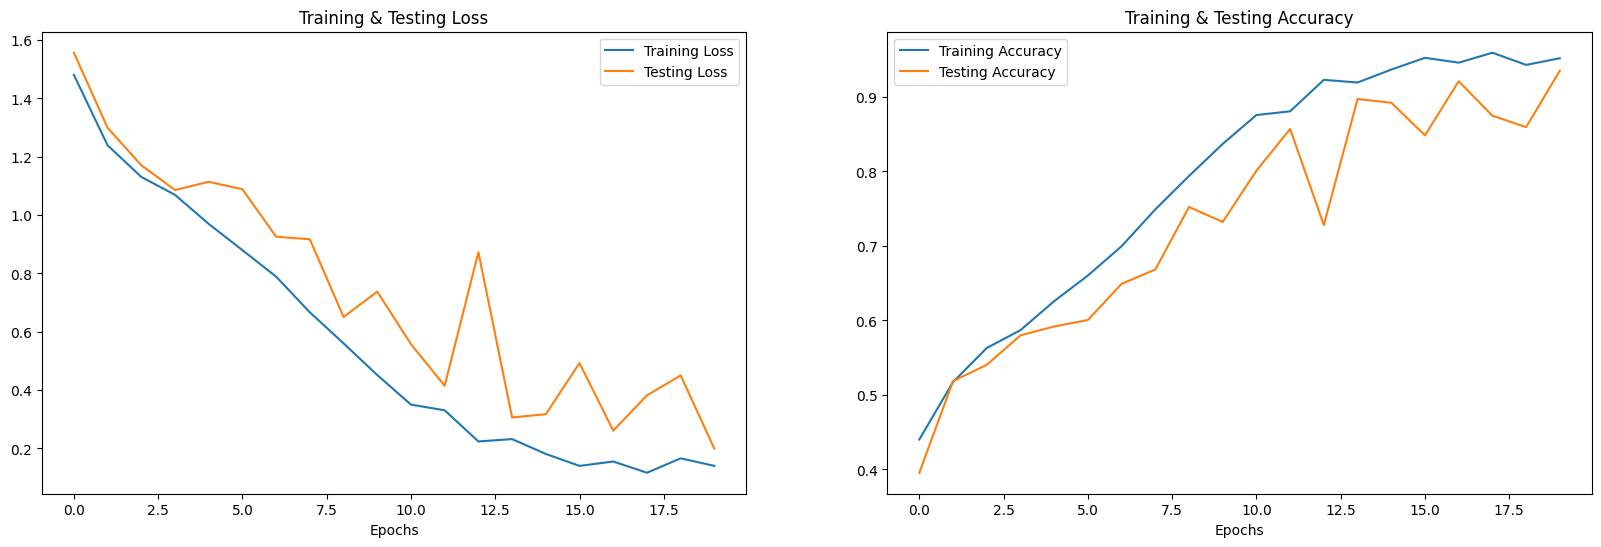

In [32]:
# ============================================================================
# STEP 15: TRAIN THE MODEL
# ============================================================================

model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

history = model.fit(x_traincnn, y_train,
                    epochs=20,
                    validation_data=(x_testcnn, y_test),
                    batch_size=64,
                    callbacks=[early_stop, lr_reduction, model_checkpoint])

# ============================================================================
# STEP 16: EVALUATE THE MODEL
# ============================================================================

print("Accuracy of our model on test data: ", model.evaluate(x_testcnn, y_test)[1]*100, "%")

epochs_range = [i for i in range(len(history.history['accuracy']))]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs_range, train_loss, label='Training Loss')
ax[0].plot(epochs_range, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs_range, train_acc, label='Training Accuracy')
ax[1].plot(epochs_range, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
  Predicted Labels Actual Labels
0              sad         angry
1              sad           sad
2              sad           sad
3             fear       disgust
4            happy         happy
5            happy          fear
6          disgust       disgust
7             fear          fear
8          neutral       neutral
9              sad           sad


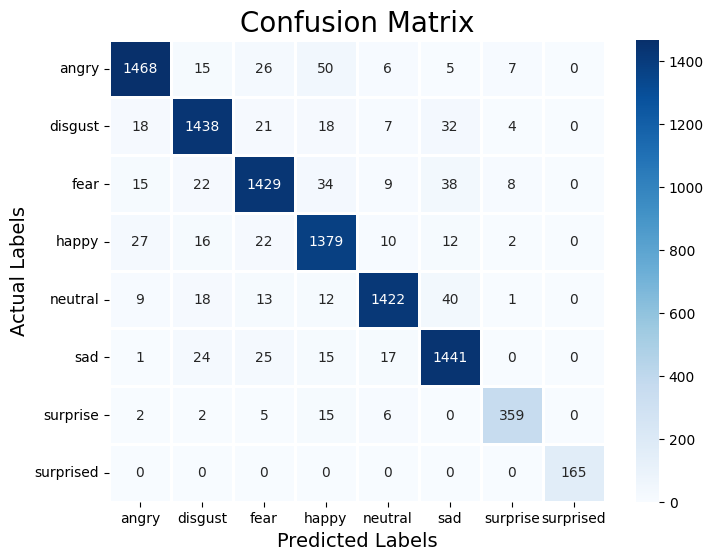

              precision    recall  f1-score   support

       angry       0.95      0.93      0.94      1577
     disgust       0.94      0.93      0.94      1538
        fear       0.93      0.92      0.92      1555
       happy       0.91      0.94      0.92      1468
     neutral       0.96      0.94      0.95      1515
         sad       0.92      0.95      0.93      1523
    surprise       0.94      0.92      0.93       389
   surprised       1.00      1.00      1.00       165

    accuracy                           0.94      9730
   macro avg       0.94      0.94      0.94      9730
weighted avg       0.94      0.94      0.94      9730



In [34]:
# ============================================================================
# STEP 17: PREDICTIONS AND CONFUSION MATRIX
# ============================================================================

pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test_labels = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_labels.flatten()

print(df.head(10))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
cm_df = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='d')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(y_test_labels, y_pred))


# **Saving Model for future use**

In [36]:
import pickle

# ====================================================================
# STEP 18: SAVE MODEL AND PREPROCESSING OBJECTS
# ====================================================================

# 1️⃣ Save model architecture to JSON
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# 2️⃣ Save model weights (must end with .weights.h5)
model.save_weights("CNN_model_weights.weights.h5")
print("Saved model architecture + weights successfully")

# 3️⃣ Save scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved StandardScaler object")

# 4️⃣ Save encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)
print("Saved OneHotEncoder object")

print("✓ All objects saved successfully")


Saved model architecture + weights successfully
Saved StandardScaler object
Saved OneHotEncoder object
✓ All objects saved successfully


# **Testing new record**

In [43]:
# =========================================================
# READY-TO-USE PREDICTION SCRIPT
# =========================================================

import numpy as np
import librosa
import pickle
from tensorflow.keras.models import load_model

# ==============================
# 1️⃣ Load saved objects
# ==============================

# Load trained model
model = load_model("/content/best_model1_weights.h5")

# Load scaler
scaler = pickle.load(open("scaler2.pickle", "rb"))

# Load encoder
encoder = pickle.load(open("encoder2.pickle", "rb"))

# ==============================
# 2️⃣ Feature extraction function
# ==============================

def get_predict_feat(path, expected_len=None):
    """
    Load audio, extract features, pad/truncate to expected length, scale, and reshape for CNN.
    Works for single audio prediction.
    """
    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features (original audio only)
    features_matrix = extract_features(data, sr)  # shape = (4, feature_len) because of augmentations
    features = features_matrix[0]  # pick only the original audio row

    # Make sure features is 1D array
    features = np.array(features).ravel()

    # Determine expected length from model if not provided
    if expected_len is None:
        expected_len = model.input_shape[1]

    # Pad or truncate
    if features.shape[0] < expected_len:
        features = np.pad(features, (0, expected_len - features.shape[0]), mode='constant')
    else:
        features = features[:expected_len]

    # Scale
    features = scaler.transform(features.reshape(1, -1))

    # Expand dims for CNN
    features = np.expand_dims(features, axis=2)

    return features


# ==============================
# 3️⃣ Prediction function
# ==============================

def predict_emotion(path):
    """
    Predict emotion for a single audio file.
    """
    # Extract features
    features = get_predict_feat(path)

    # Predict probabilities
    pred_probs = model.predict(features)

    # Get predicted class index
    pred_index = np.argmax(pred_probs, axis=1)[0]

    # Map to emotion label
    class_names = encoder.categories_[0]  # list of emotion labels
    label = class_names[pred_index]

    print(f"Predicted Emotion for {path}: {label}")
    return label



# ==============================
# 4️⃣ Test prediction on dataset files
# ==============================

# Replace 'combined_df' with your dataframe if available
# Example: predicting 3 sample audio files
sample_files = combined_df.Path.sample(3, random_state=42)

for f in sample_files:
    predict_emotion(f)

print("\n✓ All predictions completed!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion for /kaggle/input/cremad/AudioWAV/1011_TSI_ANG_XX.wav: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Emotion for /kaggle/input/cremad/AudioWAV/1060_TSI_DIS_XX.wav: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Emotion for /kaggle/input/cremad/AudioWAV/1028_TAI_HAP_XX.wav: sad

✓ All predictions completed!


In [44]:
# =========================================================
# LOAD MODEL AND PREPROCESSING OBJECTS
# =========================================================

from tensorflow.keras.models import model_from_json
import pickle
import librosa
import numpy as np

# -------------------------
# 1️⃣ Load CNN model
# -------------------------
json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/CNN_model_weights.weights.h5")
print("Loaded model from disk")

# -------------------------
# 2️⃣ Load scaler & encoder
# -------------------------
with open('/content/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

print("Scaler and Encoder loaded")

# =========================================================
# FEATURE EXTRACTION FUNCTIONS
# =========================================================

def zcr(data, frame_length=2048, hop_length=512):
    z = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(z)

def rmse(data, frame_length=2048, hop_length=512):
    r = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(r)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    m = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    return np.ravel(m.T) if flatten else np.squeeze(m.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    """
    Extract ZCR + RMSE + MFCC features from audio
    """
    result = np.array([])
    result = np.hstack((
        zcr(data, frame_length, hop_length),
        rmse(data, frame_length, hop_length),
        mfcc(data, sr, frame_length, hop_length)
    ))
    return result

# =========================================================
# PREDICTION FEATURE PREPARATION
# =========================================================

def get_predict_feat(path):
    """
    Load audio, extract features, pad/truncate, scale and reshape for CNN
    """
    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features
    features = extract_features(data, sr)
    features = np.array(features).ravel()

    # Pad or truncate to match model input
    expected_len = loaded_model.input_shape[1]
    if features.shape[0] < expected_len:
        features = np.pad(features, (0, expected_len - features.shape[0]), mode='constant')
    else:
        features = features[:expected_len]

    # Scale features
    features = scaler2.transform(features.reshape(1, -1))

    # Expand dims for CNN input
    features = np.expand_dims(features, axis=2)

    return features

# =========================================================
# PREDICTION FUNCTION
# =========================================================

def prediction(path):
    """
    Predict emotion for a single audio file
    """
    features = get_predict_feat(path)
    pred_probs = loaded_model.predict(features)
    pred_index = np.argmax(pred_probs, axis=1)[0]

    # Map index to emotion label
    class_names = encoder2.categories_[0]
    label = class_names[pred_index]

    print(f"Predicted Emotion for {path}: {label}")
    return label




Loaded model from disk
Scaler and Encoder loaded


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
# =========================================================
# TEST PREDICTION
# =========================================================

sample_path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav"
prediction(sample_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion for /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav: neutral


'neutral'

In [46]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Emotion for /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav: angry


'angry'

In [47]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Emotion for /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav: fear


'fear'

In [48]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Emotion for /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav: disgust


'disgust'